# Image Recognition with Transfer Learning (CIFAR-10 Dataset)

## Practical Test: Neural Networks & Deep Learning

This notebook implements transfer learning for image classification on the CIFAR-10 dataset using pre-trained model (MobileNetV2) and compares performance with a custom CNN.

### Dataset
- **CIFAR-10**: 60,000 32x32 color images in 10 classes
- Source: https://www.cs.toronto.edu/~kriz/cifar.html


In [3]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import time

print("TensorFlow version:", tf.__version__)
print("Library imports successful.!")


TensorFlow version: 2.20.0
Library imports successful.!


## 1. Load Dataset & Preprocessing
### Load CIFAR-10 dataset and normalize image data


Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)

After split:
Training:   (40000, 32, 32, 3), (40000,) (40000 samples)
Validation: (10000, 32, 32, 3), (10000,) (10000 samples)
Test:       (10000, 32, 32, 3), (10000,) (10000 samples)

10 sample images from the dataset


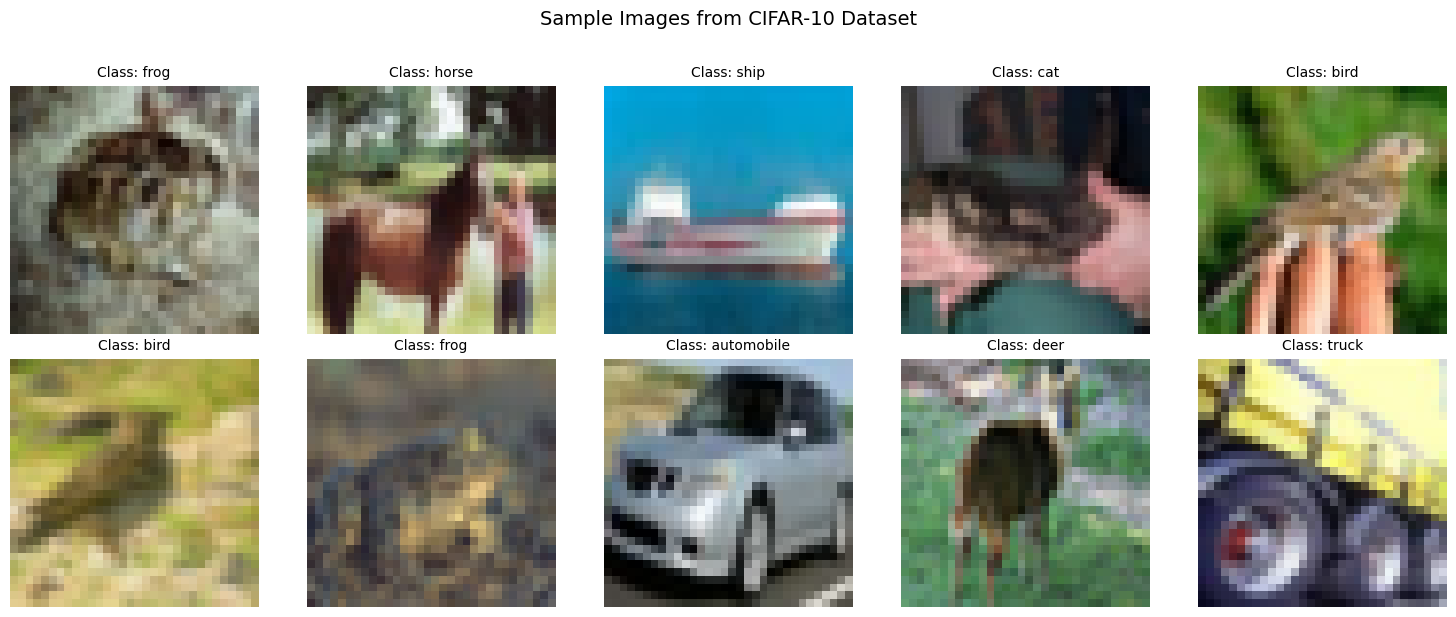

In [ ]:
# Load CIFAR-10 dataset and normalize image data

# Automatically downloads the dataset from the official source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# The dataset is cached in ~/.keras/datasets/ (or C:\Users\<username>\.keras\datasets\ on Windows)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# CIFAR-10 class names - as defined in the official dataset.
# The labels 0-9 correspond to these classes in order
class_names = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

# Create proper train/validation split with stratification (20% validation)
# This ensures balanced class distribution in both train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train  # Ensures balanced class distribution
)

print(f"\nAfter split:")
print(f"Training:   {x_train.shape}, {y_train.shape} ({len(x_train)} samples)")
print(f"Validation: {x_val.shape}, {y_val.shape} ({len(x_val)} samples)")
print(f"Test:       {x_test.shape}, {y_test.shape} ({len(x_test)} samples)")

# Visualize 10 sample images from the dataset with their labels
print("\n10 sample images from the dataset")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    sample_img = x_train[i]
    label = y_train[i]
    
    axes[row, col].imshow(sample_img)
    axes[row, col].set_title(f"Class: {class_names[label]}", fontsize=10)
    axes[row, col].axis('off')
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 2. Data Augmentation & Efficient Data Pipelines
### Apply data augmentation (rotation, flipping, shifts) and measure improvement



Visualizing augmented images


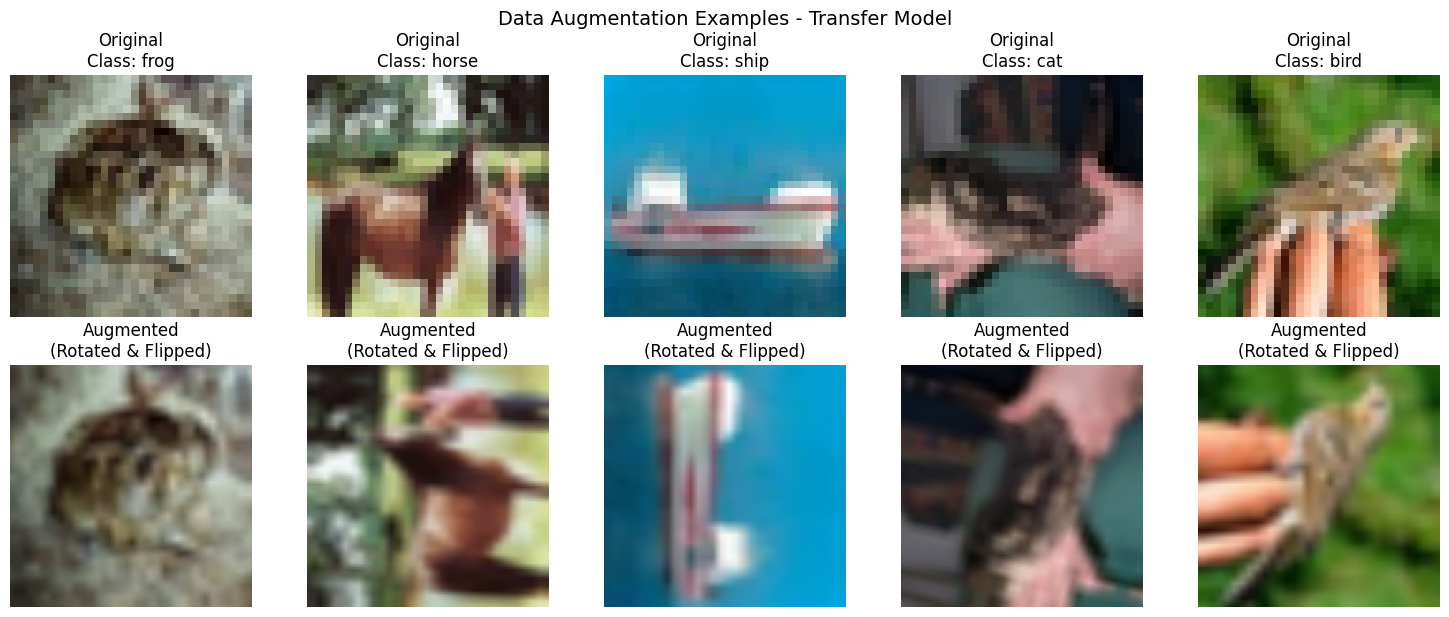

Visualizing custom CNN augmentation.


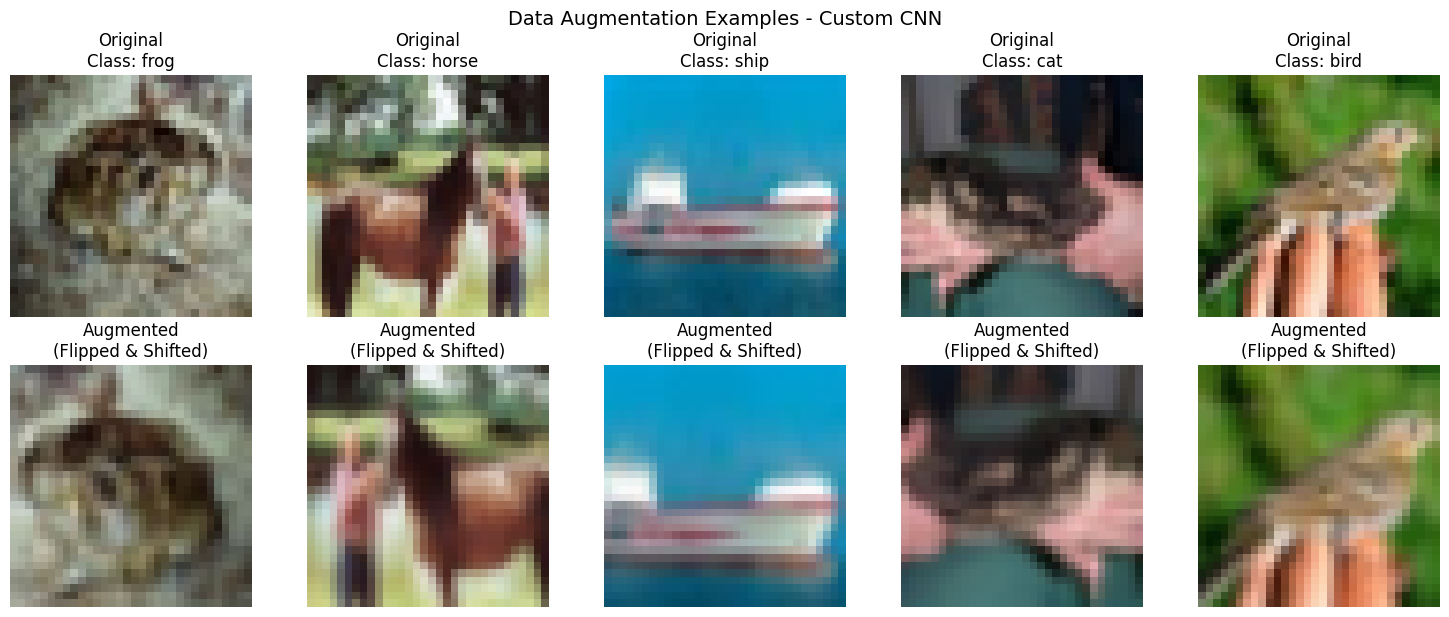

In [ ]:
# Build efficient tf.data pipelines

# BATCH_SIZE: Number of samples processed together in one training step
#With 40,000 training images and batch size 128, you get ~313 batches per epoch (40,000 ÷ 128)
BATCH_SIZE = 128

# AUTOTUNE: TensorFlow's automatic optimization for data pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

# IMG_SIZE: Target image dimensions for MobileNetV2 input
# - CIFAR-10 images are 32x32, but MobileNetV2 expects larger images
# - 96x96 is a good size: larger than 32x32 but smaller than standard 224x224
IMG_SIZE = 96  # for MobileNetV2

# Data augmentation - Apply rotation, flipping, and shifts
# - Random rotation (up to 15 degrees ≈ 0.262 radians)
# - Random horizontal flipping /vertical shifts
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(15.0 / 180.0 * np.pi),  # 15 degrees in radians
    ],
    name="data_augmentation",
)

def preprocess_for_transfer(image, label, augment=False):
    # Original CIFAR is 32x32; resize for MobileNetV2
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # MobileNetV2 preprocessing
    if augment:
        image = data_augmentation(image)
    return image, label

def preprocess_for_custom_cnn(image, label, augment=False):
    if augment:
        # Horizontal flipping and shifts
        image = tf.image.random_flip_left_right(image)
        # Random horizontal and vertical shifts (10% range = ~3 pixels for 32x32)
        # Use padding + random crop to simulate translation
        image = tf.image.resize_with_pad(image, 38, 38)  # Add 6 pixels padding (3 on each side)
        image = tf.image.random_crop(image, [32, 32, 3])  # Random crop back to 32x32
    return image, label

# Training dataset for transfer model
train_ds_transfer = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=True),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Test dataset for transfer model
test_ds_transfer = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Training dataset for custom CNN
train_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=True),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Validation dataset for custom CNN (use proper validation set, NOT test set)
val_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Test dataset for custom CNN
test_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


# Visualize augmented images.
print("\nVisualizing augmented images")

# Create augmentation layers once for visualization
viz_flip_layer = layers.RandomFlip("horizontal", seed=42)
viz_rotation_layer = layers.RandomRotation(15.0 / 180.0 * np.pi, seed=42)

# Build layers with a dummy input to ensure proper initialization
dummy_input = tf.zeros((1, IMG_SIZE, IMG_SIZE, 3))
_ = viz_flip_layer(dummy_input, training=True)
_ = viz_rotation_layer(dummy_input, training=True)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original image
    sample_img = x_train[i]
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title(f"Original\nClass: {class_names[y_train[i]]}")
    axes[0, i].axis('off')
    
    # Augmented image - resize and apply augmentation for visualization
    # Ensure correct shape: (batch, height, width, channels)
    img_resized = tf.expand_dims(sample_img, 0)  # Add batch dimension: (1, 32, 32, 3)
    img_resized = tf.image.resize(img_resized, (IMG_SIZE, IMG_SIZE))  # (1, 96, 96, 3)
    # Apply augmentation layers
    aug_img = viz_flip_layer(img_resized, training=True)
    aug_img = viz_rotation_layer(aug_img, training=True)
    aug_img = aug_img.numpy()[0]  # Remove batch dimension: (96, 96, 3)
    # Clip to valid range for display
    aug_img = np.clip(aug_img, 0, 1)
    axes[1, i].imshow(aug_img)
    axes[1, i].set_title("Augmented\n(Rotated & Flipped)")
    axes[1, i].axis('off')
plt.tight_layout()
plt.suptitle("Data Augmentation Examples - Transfer Model", y=1.02, fontsize=14)
plt.show()

# Also visualize custom CNN augmentation
print("Visualizing custom CNN augmentation.")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    sample_img = x_train[i]
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title(f"Original\nClass: {class_names[y_train[i]]}")
    axes[0, i].axis('off')
    
    # Apply custom CNN augmentation
    aug_img, _ = preprocess_for_custom_cnn(sample_img, y_train[i], augment=True)
    aug_img = aug_img.numpy() if hasattr(aug_img, 'numpy') else aug_img
    axes[1, i].imshow(aug_img)
    axes[1, i].set_title("Augmented\n(Flipped & Shifted)")
    axes[1, i].axis('off')
plt.tight_layout()
plt.suptitle("Data Augmentation Examples - Custom CNN", y=1.02, fontsize=14)
plt.show()

## 3. Transfer Learning Model (MobileNetV2)
### Use a pre-trained model (MobileNetV2) for transfer learning


In [7]:
# Use pre-trained MobileNetV2 for transfer learning

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # Direct input at MobileNetV2 size
# Note: Preprocessing and data augmentation are handled in the data pipeline

base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze lower layers (entire base model)

# Add new top layers that will be trained (these are the "top layers" to retrain)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation="softmax", dtype="float32")(x)  # Top layers retrained for 10 epochs

transfer_model = models.Model(inputs, outputs, name="mobilenetv2_transfer")
transfer_model.summary()


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Train Transfer Model (Frozen Base)
### Freeze lower layers, retrain top layers for 10 epochs


In [8]:
# Freeze lower layers, retrain top layers for 10 epochs

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FROZEN = 10

# Use the stratified train/validation split created earlier
# Create training dataset
# With 40,000 training images and batch size 128, you get ~313 batches per epoch (40,000 ÷ 128)
train_ds_transfer_split = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=True),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Validation dataset
val_ds_transfer = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Custom callback to track dataset counts per epoch
class DatasetCountCallback(tf.keras.callbacks.Callback):
    def __init__(self, samples_per_epoch, batch_size):
        super().__init__()
        self.samples_per_epoch = samples_per_epoch
        self.batch_size = batch_size
        # Use ceiling division to match TensorFlow's behavior (includes partial batch)
        import math
        self.batches_per_epoch = math.ceil(samples_per_epoch / batch_size)
        self.epoch_samples = []
        self.total_samples = 0
        # Track metrics
        self.train_accuracies = []
        self.train_losses = []
        self.val_accuracies = []
        self.val_losses = []
        # Track timing
        self.epoch_times = []
        self.epoch_start_time = None
    
    def on_epoch_begin(self, epoch, logs=None):
        # Print at the start of each epoch (only once per epoch)
        if epoch == 0:
            print(f"Starting Training: {EPOCHS_FROZEN} epochs, {self.samples_per_epoch:,} training samples per epoch ({self.batches_per_epoch} batches)")
            print(f"{'_'*70}\n")
            
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        # Each epoch processes all training samples
        self.epoch_samples.append(self.samples_per_epoch)
        self.total_samples += self.samples_per_epoch
        
        # Capture metrics from logs
        if logs:
            self.train_accuracies.append(logs.get('accuracy', 0))
            self.train_losses.append(logs.get('loss', 0))
            self.val_accuracies.append(logs.get('val_accuracy', 0))
            self.val_losses.append(logs.get('val_loss', 0))
        

    def on_train_end(self, logs=None):
        print("\n" + "="*70)
        print("DATASET TRAINING SUMMARY")
        print("_"*70)
        print(f"Training Dataset: {self.samples_per_epoch:,} images (after 80/20 split from 50,000)")
        print(f"Batch Size: {self.batch_size}")
        print(f"Batches per Epoch: {self.batches_per_epoch} ({self.samples_per_epoch:,} ÷ {self.batch_size} = {self.batches_per_epoch} batches, including partial batch)")
        print("-"*70)
        for epoch, samples in enumerate(self.epoch_samples, 1):
            print(f"Epoch {epoch}: {samples:,} training samples ({self.batches_per_epoch} batches)")
        print("-"*70)
        total_batches = self.batches_per_epoch * len(self.epoch_samples)
        print(f"Total training samples across all {len(self.epoch_samples)} epochs: {self.total_samples:,}")
        print(f"Total batches processed: {total_batches:,} ({self.batches_per_epoch} batches × {len(self.epoch_samples)} epochs)")
        print(f"Average samples per epoch: {self.total_samples / len(self.epoch_samples):,.0f}")
        
        # Performance Metrics Section
        if self.train_accuracies and self.train_losses:
            print("\n" + "_"*70)
            print("PERFORMANCE METRICS")
            print("_"*70)
            
            # Training accuracy progression
            first_acc = self.train_accuracies[0]
            last_acc = self.train_accuracies[-1]
            acc_improvement = last_acc - first_acc
            print(f"Training Accuracy:")
            print(f"  - Epoch 1: {first_acc:.4f} ({first_acc*100:.2f}%)")
            print(f"  - Epoch {len(self.train_accuracies)}: {last_acc:.4f} ({last_acc*100:.2f}%)")
            print(f"  - Improvement: {acc_improvement:.4f} ({acc_improvement*100:.2f}% increase)")
            
            # Training loss progression
            first_loss = self.train_losses[0]
            last_loss = self.train_losses[-1]
            loss_decrease = first_loss - last_loss
            print(f"\nTraining Loss:")
            print(f"  - Epoch 1: {first_loss:.4f}")
            print(f"  - Epoch {len(self.train_losses)}: {last_loss:.4f}")
            print(f"  - Decrease: {loss_decrease:.4f} ({loss_decrease/first_loss*100:.2f}% reduction)")
            
            # Validation metrics
            if self.val_accuracies:
                val_acc_min = min(self.val_accuracies)
                val_acc_max = max(self.val_accuracies)
                val_acc_avg = sum(self.val_accuracies) / len(self.val_accuracies)
                print(f"\nValidation Accuracy:")
                print(f"  - Range: {val_acc_min:.4f} - {val_acc_max:.4f} ({val_acc_min*100:.2f}% - {val_acc_max*100:.2f}%)")
                print(f"  - Average: {val_acc_avg:.4f} ({val_acc_avg*100:.2f}%)")
            
            if self.val_losses:
                val_loss_min = min(self.val_losses)
                val_loss_max = max(self.val_losses)
                val_loss_avg = sum(self.val_losses) / len(self.val_losses)
                print(f"\nValidation Loss:")
                print(f"  - Range: {val_loss_min:.4f} - {val_loss_max:.4f}")
                print(f"  - Average: {val_loss_avg:.4f}")
            
            # Training efficiency
            if self.epoch_times:
                min_epoch_time = min(self.epoch_times)
                max_epoch_time = max(self.epoch_times)
                avg_epoch_time = sum(self.epoch_times) / len(self.epoch_times)
                total_training_time = sum(self.epoch_times)
                
                # Calculate time per step (batch)
                avg_time_per_step = avg_epoch_time / self.batches_per_epoch * 1000  # Convert to ms
                min_time_per_step = min_epoch_time / self.batches_per_epoch * 1000
                max_time_per_step = max_epoch_time / self.batches_per_epoch * 1000
                
                print(f"\nTraining Efficiency:")
                print(f"  - Time per epoch: {min_epoch_time:.0f}s - {max_epoch_time:.0f}s (avg: {avg_epoch_time:.0f}s)")
                print(f"  - Time per step (batch): {min_time_per_step:.0f}ms - {max_time_per_step:.0f}ms (avg: {avg_time_per_step:.0f}ms)")
                print(f"  - Total training time: {total_training_time:.0f}s ({total_training_time/60:.1f} minutes)")
        
        print("="*70)

# Calculate number of training samples per epoch
# With 40,000 training images and batch size 128, you get 313 batches per epoch (40,000 ÷ 128 = 312.5, rounded up to 313 including partial batch)
samples_per_epoch = len(x_train)  # 40,000 samples (after train/validation split)
dataset_callback = DatasetCountCallback(samples_per_epoch, BATCH_SIZE)
history_frozen = transfer_model.fit(
    train_ds_transfer_split,
    epochs=EPOCHS_FROZEN,
    validation_data=val_ds_transfer,
    callbacks=[dataset_callback],
)


Starting Training: 10 epochs, 40,000 training samples per epoch (313 batches)
______________________________________________________________________

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 472ms/step - accuracy: 0.1036 - loss: 2.4352 - val_accuracy: 0.1065 - val_loss: 2.3167
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 470ms/step - accuracy: 0.1023 - loss: 2.3439 - val_accuracy: 0.1000 - val_loss: 2.3037
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 475ms/step - accuracy: 0.1054 - loss: 2.3255 - val_accuracy: 0.1000 - val_loss: 2.3107
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 480ms/step - accuracy: 0.1092 - loss: 2.3205 - val_accuracy: 0.1330 - val_loss: 2.3015
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 473ms/step - accuracy: 0.1122 - loss: 2.3164 - val_accuracy: 0.1365 - val_loss: 2.3073
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 469ms/step - accuracy: 0.1148 - loss: 2.3121 - val_accuracy: 0.1182 - val_loss: 2.2933
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 478ms/step - 

## 5. Fine-Tune Top Layers
### Experiment with fine-tuning different layers and learning rates


In [9]:
# Experiment with fine-tuning different layers and learning rates

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # smaller LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FINE_TUNE = 5

history_transfer_finetune = transfer_model.fit(
    train_ds_transfer_split,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_ds_transfer,
    verbose=1,
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 256s 772ms/step - accuracy: 0.2480 - loss: 2.3077 - val_accuracy: 0.1000 - val_loss: 2.9783
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 234s 747ms/step - accuracy: 0.3178 - loss: 1.9005 - val_accuracy: 0.1000 - val_loss: 2.6724
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 238s 760ms/step - accuracy: 0.3462 - loss: 1.8200 - val_accuracy: 0.1000 - val_loss: 2.6204
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 251s 801ms/step - accuracy: 0.3688 - loss: 1.7686 - val_accuracy: 0.1000 - val_loss: 3.0509
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 235s 752ms/step - accuracy: 0.3806 - loss: 1.7354 - val_accuracy: 0.1000 - val_loss: 2.6806


## 6. Custom CNN (From Scratch)
### Compare performance with a custom CNN built from scratch


In [10]:
# Build custom CNN from scratch for performance comparison

def make_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", padding="same",
                      input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ])
    return model

custom_cnn = make_custom_cnn()
custom_cnn.summary()

custom_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_CUSTOM = 10

history_custom = custom_cnn.fit(
    train_ds_custom,
    epochs=EPOCHS_CUSTOM,
    validation_data=val_ds_custom,  # Use proper validation set (NOT test set)
    verbose=1,
)


c:\Users\Ainedembe-Denis\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,282 (2.37 MB)

 Trainable params: 621,322 (2.37 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.4297 - loss: 1.7051 - val_accuracy: 0.2515 - val_loss: 2.6389
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.5721 - loss: 1.2083 - val_accuracy: 0.5144 - val_loss: 1.5093
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.6282 - loss: 1.0555 - val_accuracy: 0.5362 - val_loss: 1.4560
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.6607 - loss: 0.9633 - val_accuracy: 0.6068 - val_loss: 1.2049
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.6873 - loss: 0.8996 - val_accuracy: 0.6197 - val_loss: 1.0911
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.7045 - loss: 0.8474 - val_accuracy: 0.6519 - val_loss: 1.0377
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.7176 - loss: 0.8131 - val_accuracy: 0.6378 - val_loss: 1.1284
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step - accuracy: 0.7256 - loss: 0

## 7. Evaluation, Confusion Matrix, and Predictions
### Evaluate accuracy and confusion matrix; visualize class predictions
### Compare performance with custom CNN (continued)


Transfer (fine-tuned) test accuracy: 0.10000000149011612
Custom CNN test accuracy: 0.6708999872207642
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step
Confusion matrix shape: (10, 10)


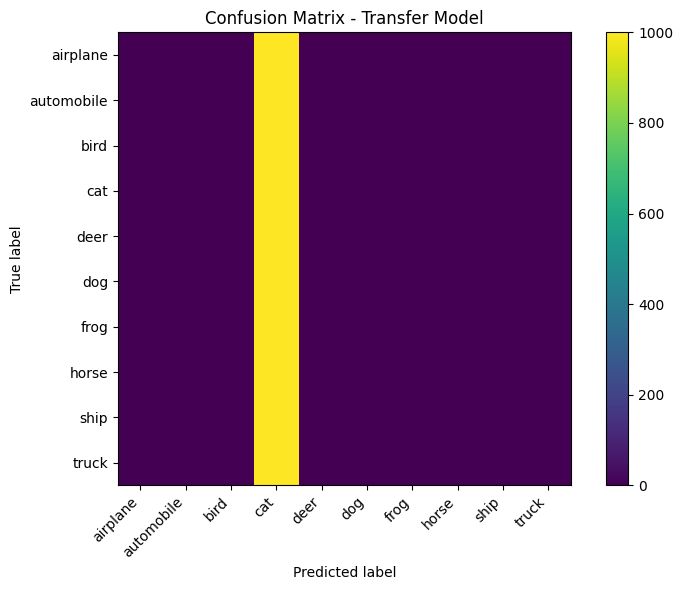

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.10      1.00      0.18      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


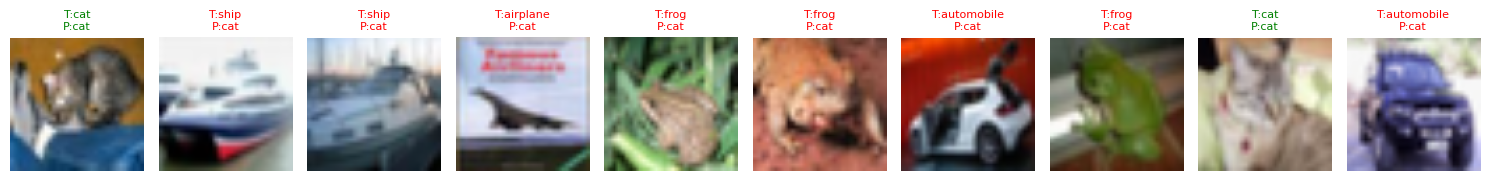

In [11]:
# Evaluate accuracy and confusion matrix; visualize predictions
# Compare performance with custom CNN

# Transfer model
test_loss_t, test_acc_t = transfer_model.evaluate(test_ds_transfer, verbose=0)
print("Transfer (fine-tuned) test accuracy:", test_acc_t)

# Custom CNN
test_loss_c, test_acc_c = custom_cnn.evaluate(test_ds_custom, verbose=0)
print("Custom CNN test accuracy:", test_acc_c)

# Predictions for confusion matrix (transfer model)
y_pred_probs = transfer_model.predict(test_ds_transfer)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from dataset pipeline
y_true = np.concatenate([y for _, y in test_ds_transfer], axis=0)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Transfer Model")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Show some sample predictions
def show_sample_predictions(dataset, class_names, model, n=10):
    images = []
    labels = []
    for batch_images, batch_labels in dataset.take(1):
        images = batch_images.numpy()
        labels = batch_labels.numpy()
        break

    preds = model.predict(dataset.take(1))
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = images[i]
        # If image was preprocessed, undo scaling if needed
        # For MobileNetV2 we can just clip to [0,1] for visualization
        img_vis = np.clip((img - img.min()) / (img.max() - img.min() + 1e-7), 0, 1)

        plt.subplot(1, n, i+1)
        plt.imshow(img_vis)
        color = "green" if labels[i] == pred_labels[i] else "red"
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}", fontsize=8, color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_predictions(test_ds_transfer, class_names, transfer_model, n=10)
